# Setting Parameters

In [2]:
# Params
RANDOM_SEED = 45
BATCH_SIZE = 64

# Loading Packages

In [3]:
# Importing Packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import os

# Loading Data

## Prep Data into DataFrame

In [4]:
# download from kaggle
# First check if the dataset is already downloaded
if not os.path.exists('./data/cartoon-faces-googles-cartoon-set.zip'):
    # Download the dataset
    !pip install kaggle
    !kaggle datasets download -d brendanartley/cartoon-faces-googles-cartoon-set -p ./data
else:
    print("Dataset already downloaded")

Dataset already downloaded


In [5]:
# unzip files in python
import zipfile

# get current directory
home_dir = os.getcwd()

# unzip, if not already unzipped
if not os.path.exists(home_dir + '/data/cartoonset100k_jpg'):
    with zipfile.ZipFile(home_dir + '/data/cartoon-faces-googles-cartoon-set.zip', 'r') as zip_ref:
        zip_ref.extractall(home_dir + '/data')
else:
    print("Dataset already unzipped")

Dataset already unzipped


In [6]:
# Put file paths in a DataFrame

# initialize dataframe
data = pd.DataFrame(columns=["path"])

# Initialize directory and translate dict (only use first 10k images)
dir = home_dir +  "/data/cartoonset100k_jpg/0"

for subdir in os.listdir(dir):
    data.loc[len(data)] = [dir + "/" + subdir]

print(f"There are {len(data)} images in the dataset")
data.head()

There are 10000 images in the dataset


,path
0,/home/adam-taback/Desktop/APS360/Project/Final...
1,/home/adam-taback/Desktop/APS360/Project/Final...
2,/home/adam-taback/Desktop/APS360/Project/Final...
3,/home/adam-taback/Desktop/APS360/Project/Final...
4,/home/adam-taback/Desktop/APS360/Project/Final...


## Load into PyTorch

In [7]:
# import packages
from torch.utils.data import Dataset
from PIL import Image

### Define Dataset Class

In [8]:
# Define Dataset
class CartoonDataset(Dataset):
    def __init__(self, X, transform=None):
        self.X = np.asarray(X).ravel()
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img_path = self.X[idx]
        # print(f"Opening image: {img_path}")
        img = Image.open(img_path).convert("RGB")
        if self.transform is not None:
            img = self.transform(img)
        return img


    def show_img(self, idx):
        '''Plot image'''
        img = self.__getitem__(idx)
        if img is not None:
            img = img.numpy().transpose((1, 2, 0))
            plt.figure(figsize=(16, 8))
            plt.axis('off')
            plt.imshow(img)
            plt.pause(0.001)

### Define Transforms

In [14]:
# Define Transforms
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize(0,1)
])

### Generate Datasets and Plot examples

In [15]:
# Generate DataSets

cartoon_set = CartoonDataset(data["path"],transform=transform)

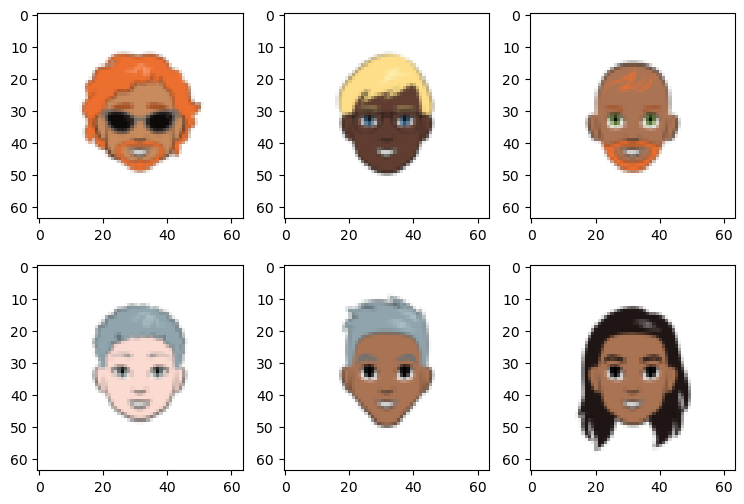

In [16]:
# Plot first 9 images

# define plot
fig, axes = plt.subplots(2, 3, figsize=(9, 6))

# iterate
for i in range(2):
  for j in range(3):
    img = cartoon_set[i*3 + j]
    img = img.numpy().transpose((1, 2, 0))
    axes[i,j].imshow(img)

### Prep Dataloaders

In [17]:
# make dataloader
from torch.utils.data import DataLoader

cartoon_loader = DataLoader(cartoon_set, batch_size=BATCH_SIZE, shuffle=False)

# Baseline Model

# Primary Model

In [18]:
# import packages
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as utils

In [35]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [36]:
# size of generator feature maps
sizeGF = 128
# size of discriminator feature maps
sizeDF = 128

## Generator

In [37]:
class Generator(nn.Module):
    def __init__(self, n_channels = 3, size_noise = 100):
        super(Generator, self).__init__()

        self.layers = nn.Sequential(
            nn.ConvTranspose2d(size_noise, sizeGF * 8, 4, 1, 0, bias=False),  # 1x1 -> 4x4
            nn.BatchNorm2d(sizeGF * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(sizeGF * 8, sizeGF * 4, 4, 2, 1, bias=False),  # 4x4 -> 8x8
            nn.BatchNorm2d(sizeGF * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(sizeGF * 4, sizeGF * 2, 4, 2, 1, bias=False),  # 8x8 -> 16x16
            nn.BatchNorm2d(sizeGF * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(sizeGF * 2, sizeGF, 4, 2, 1, bias=False),  # 16x16 -> 32x32
            nn.BatchNorm2d(sizeGF),
            nn.ReLU(True),

            nn.ConvTranspose2d(sizeGF, n_channels, 4, 2, 1, bias=False),  # 32x32 -> 64x64
            nn.Tanh()
        )

    def forward(self, input):
        return self.layers(input)

## Discriminator

In [38]:
class Discriminator(nn.Module):
    def __init__(self, n_channels=3):
        super(Discriminator, self).__init__()

        self.main = nn.Sequential(
            nn.Conv2d(n_channels, sizeDF, 4, 2, 1, bias=False),  # 64x64 -> 32x32
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(sizeDF, sizeDF * 2, 4, 2, 1, bias=False),  # 32x32 -> 16x16
            nn.BatchNorm2d(sizeDF * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(sizeDF * 2, sizeDF * 4, 4, 2, 1, bias=False),  # 16x16 -> 8x8
            nn.BatchNorm2d(sizeDF * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(sizeDF * 4, sizeDF * 8, 4, 2, 1, bias=False),  # 8x8 -> 4x4
            nn.BatchNorm2d(sizeDF * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(sizeDF * 8, sizeDF * 16, 4, 2, 1, bias=False),  # 4x4 -> 2x2
            nn.BatchNorm2d(sizeDF * 16),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(sizeDF * 16, 1, 2, 1, 0, bias=False),  # 2x2 -> 1x1
            nn.Sigmoid()
        )

    def forward(self, input):
        output = self.main(input)
        output = output.view(output.size(0), -1)  # Flatten the output
        return output

## Training

Function to save images at each epoch

In [41]:
# import vutils
import torchvision.utils as vutils

# Function to plot and save generated images
def plot_generated_images(generator, fixed_noise, epoch):
    with torch.no_grad():
        fake = generator(fixed_noise).detach().cpu()
    grid = vutils.make_grid(fake, nrow=8, padding=2, normalize=True)
    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.title(f"Generated Images from epoch {epoch}")
    plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
    plt.savefig(f"gan_training_frames/epoch_{epoch}.png")
    plt.close()

# Training Loop

In [42]:
# Hyperparameters
nepochs = 10
lr = 0.0001
size_noise = 100
n_channels = 3
batch_size = BATCH_SIZE

# Define discriminator and generator
discriminator = Discriminator(n_channels).to(device)
generator = Generator(n_channels, size_noise).to(device)

# Optimizers
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr/4, betas=(0.5, 0.999))
g_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

# Labels for real and fake images
real_label = 1.0
fake_label = 0.0

# Loss function
criterion = nn.BCELoss()

# Function to generate noise
def generate_noise(batch_size, noise_dim):
    return torch.randn(batch_size, noise_dim, 1, 1, device=device)

# Directory to save frames and models
os.makedirs("gan_training_frames", exist_ok=True)
os.makedirs("models/cartoon_gan", exist_ok=True)

# Initialize fixed noise for generating images
fixed_noise = generate_noise(batch_size, size_noise)

for epoch in range(nepochs):
    # Check if model has already reached the epoch
    if os.path.exists(f"models/cartoon_gan/generator_epoch_{epoch + 1}.pth"):
        print(f"Model already trained for epoch {epoch + 1}")
        
        # Load models
        generator.load_state_dict(torch.load(f"models/cartoon_gan/generator_epoch_{epoch + 1}.pth"))
        discriminator.load_state_dict(torch.load(f"models/cartoon_gan/discriminator_epoch_{epoch + 1}.pth"))
        
        # Generate and plot images
        plot_generated_images(generator, fixed_noise, epoch + 1)
        
        continue
    
    generator.train()
    discriminator.train()
    cum_d_loss = 0.
    cum_g_loss = 0.
    
    for i, data in enumerate(cartoon_loader, 0):
        # Get the next set of real images to be used in this iteration
        images = data
        images = images.to(device)
        b_size = images.size(0)
        
        # Generate noise and fake images
        noise_data = generate_noise(b_size, size_noise)
        generated_images = generator(noise_data)
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        discriminator.zero_grad()
        # Train with real batch
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        output_real = discriminator(images).view(-1)
        errD_real = criterion(output_real, label)
        errD_real.backward()
        D_x = output_real.mean().item()
        
        # Train with fake batch
        label.fill_(fake_label)
        output_fake = discriminator(generated_images.detach()).view(-1)
        errD_fake = criterion(output_fake, label)
        errD_fake.backward()
        D_G_z1 = output_fake.mean().item()
        errD = errD_real + errD_fake
        d_optimizer.step()
        
        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        generator.zero_grad()
        label.fill_(real_label)
        output_fake = discriminator(generated_images).view(-1)
        errG = criterion(output_fake, label)
        errG.backward()
        g_optimizer.step()
        D_G_z2 = output_fake.mean().item()
        
        # Accumulate Losses
        cum_d_loss += errD.item()
        cum_g_loss += errG.item()

    print(f'Epoch: {epoch + 1}, Generator Loss: {cum_g_loss / len(cartoon_loader)}, Discriminator Loss: {cum_d_loss / len(cartoon_loader)}')
    
    # Plot and save images after each epoch
    plot_generated_images(generator, fixed_noise, epoch + 1)
        
    # Save models after each epoch
    torch.save(generator.state_dict(), f"models/cartoon_gan/generator_epoch_{epoch + 1}.pth")
    torch.save(discriminator.state_dict(), f"models/cartoon_gan/discriminator_epoch_{epoch + 1}.pth")

print("Training complete!")

# Create an animation
frames = []
for epoch in range(nepochs):
    frame = Image.open(f"gan_training_frames/epoch_{epoch + 1}.png")
    frames.append(frame)

# Save as GIF
frames[0].save('gan_training_animation.gif', format='GIF',
               append_images=frames[1:], save_all=True, duration=300, loop=0)

Epoch: 1, Generator Loss: 7.359114438864835, Discriminator Loss: 0.030256449043228748


# Plotting Final Images

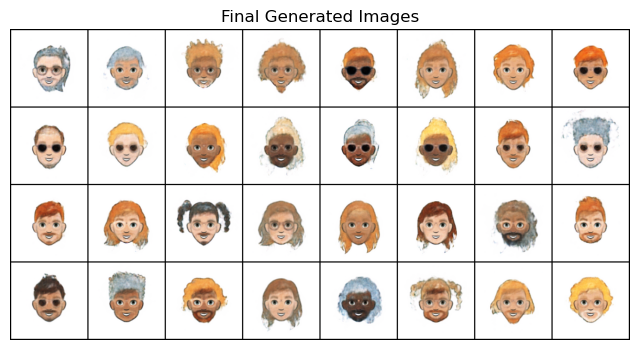

In [34]:
# load model
device = "cpu"

# Load the model
generator = Generator(n_channels, size_noise).to(device)
generator.load_state_dict(torch.load("models/cartoon_gan/generator_epoch_10.pth", map_location=device))

# Generate images
fixed_noise = generate_noise(32, size_noise)
generator.eval()
generated_images = generator(fixed_noise).detach().cpu()

# Create a grid of generated images
grid = vutils.make_grid(generated_images, nrow=8, padding=2, normalize=True)

# Plotting the images
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title(f"Final Generated Images")
plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))

# Calculating Frechet Inception Distance

In [35]:
from torchvision.models import inception_v3
from scipy.linalg import sqrtm
import torch.nn.functional as F

def calculate_fid(real_images, generated_images, batch_size=32):
    model = inception_v3(pretrained=True, transform_input=False).to(device)
    model.eval()

    def get_activations(images):
        images = F.interpolate(images, size=(299, 299), mode='bilinear', align_corners=False)
        with torch.no_grad():
            pred = model(images)
        return pred.cpu().numpy()

    real_activations = get_activations(real_images)
    generated_activations = get_activations(generated_images)

    mu1, sigma1 = real_activations.mean(axis=0), np.cov(real_activations, rowvar=False)
    mu2, sigma2 = generated_activations.mean(axis=0), np.cov(generated_activations, rowvar=False)

    ssdiff = np.sum((mu1 - mu2) ** 2.0)
    covmean = sqrtm(sigma1.dot(sigma2))

    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)

    return fid

In [39]:
# Calculate FID

sample_size = 1000

# First get real images
real_images = []
for i in range(sample_size):
    img = cartoon_set[i]
    real_images.append(img)
    
real_images = torch.stack(real_images).to(device)

# Get newly generated images
generated_images = generator(generate_noise(sample_size, size_noise)).detach().cpu()

# Calculate FID
fid = calculate_fid(real_images, generated_images)

/home/adam-taback/miniconda3/envs/pytorch_env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/adam-taback/miniconda3/envs/pytorch_env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
print(f"FID: {fid}")

(493.7974564479706, 1000)